In [423]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import cx_Oracle
import os
import warnings
warnings.filterwarnings('ignore')

In [424]:
if os.path.exists('data_q.csv'):
    df = pd.read_csv('data_q.csv')
else:
    con = cx_Oracle.connect(user='common',password='Nwpass_Rkcol_0819',
                                    dsn='dwproddc',encoding = 'utf-8',
                                    nencoding = 'utf-8')
    sql = """select a.month,a.unit_code, a.result_check
             from HH_CHECK_QUINTILE_10 a"""
    df = pd.read_sql(sql, con)
    df.to_csv('data_q.csv', index=None)
df.head()
#df.dropna(inplace=True)

,MONTH,UNIT_CODE,RESULT_CHECK
0,2019/05,FC4260,0.638606
1,2019/05,FC4130,0.621353
2,2019/05,FC4129,0.620395
3,2019/05,FC4173,0.603339
4,2019/05,FC4050,0.591735


In [425]:
df.head(10)

,MONTH,UNIT_CODE,RESULT_CHECK
0,2019/05,FC4260,0.638606
1,2019/05,FC4130,0.621353
2,2019/05,FC4129,0.620395
3,2019/05,FC4173,0.603339
4,2019/05,FC4050,0.591735
5,2019/05,FC4048,0.589044
6,2019/05,FC4202,0.536343
7,2019/05,FC4078,0.504163
8,2019/05,FC4067,0.485563
9,2019/05,FC4096,0.480738


Trong quá trình hoạt động của doanh nghiệp, việc đánh giá nhân viên luôn rất quan trọng. Nhà quản trị luôn cần đánh giá nhân sự một các khoa học và chính xác, từ đó đưa ra các quyết định về nhân sự như:
    - Khen thưởng nhân viên xuất sắc
    - Kiểm điểm yếu kém 
    - Tăng cường đào tạo nhân lực yếu.
    - Xa thải các trường hợp không đáp ứng yêu cầu.

Dữ liệu phân tích gồm kêt quả của mỗi nhân viên trong nhiều tháng liên tiếp, biến outcome chính là kết quả của tháng tiếp theo. Các giá trị có dạng int và nằm trong khoảng [1,10]

Bài toán: chúng ta cần dự đoán xem kết quả kinh doanh tháng tiếp theo của mỗi nhân viên.

## Các tham số chính :

In [426]:
NBIN = 10 # số bin đã chia
shapex = 4 # số tháng lịch sử
shapey = 1 # số tháng tương lai

weight = [0.2, 0.2, 0.25, 0.35]
targets = [
    [[9,10],'20%'],
    [[8,9,10],'30%'],
]
          
    
cmap = palette=sns.color_palette("RdBu_r",NBIN)

In [427]:
def bin_data(df, nbin = 10):
    dt = pd.DataFrame()
    for month in sorted(df['MONTH'].unique()) :
        temp = df[df['MONTH'] == month]
        cuts = pd.qcut(temp['RESULT_CHECK'], q=nbin, precision=10).unique()
        for i,cut in enumerate(cuts.categories):
            temp.loc[(temp['RESULT_CHECK'] > cut.left) &(temp['RESULT_CHECK'] <= cut.right),'QUINTILE'] =  nbin - i 
        dt = dt.append(temp)
    dt.reset_index(drop=True, inplace=True)
    return dt

df = bin_data(df, nbin=NBIN)
#print(df.QUINTILE.value_counts())
print(df.shape)

(13849, 4)


In [428]:
# get month frame
def processings_data(fc_code='UNIT_CODE'):
    num_month = shapex + shapey
    data = pd.DataFrame()
    for i in range(num_month, len(df.MONTH.unique())+1):
        months = df.MONTH.unique()[i-num_month:i]
        outmonths = months[-shapey:]
        # select exist 'UNIT_CODE_DESC'
        months_df = [df[df.MONTH == months[i]][fc_code].tolist() for i in range(shapex-1)] 
        for i, x in enumerate(months_df):
            if i == 0:
                fc_list = list(set(x)) 
            else: 
                fc_list = list(set(fc_list) & set(x))
        for i,month in enumerate(months):
            dt_temp = df[df.MONTH == month][[fc_code,'QUINTILE']]
            dt_temp.set_index(fc_code, inplace=True)
            col_name = f'QUINTILE_{i}'
            dt_temp.columns = [month]
            if i == 0:
                df_temp = dt_temp
            else:
                df_temp = pd.concat([df_temp, dt_temp], axis=1, sort=True)      
        df_temp.dropna(subset=months[:shapex], inplace=True)
        df_temp['outcome'] = df_temp.loc[:, outmonths].mean(axis=1)
        df_temp.drop(outmonths, axis=1, inplace=True)
        df_temp.columns = [f't-{i}' for i in range(shapex-1, -1, -1)]+['outcome']
        data = data.append(df_temp)
    data.reset_index(drop=True, inplace=True)
    #print(data.shape)
    data.fillna(NBIN, inplace=True)
    
    return data

data = processings_data()
print(data.shape)
print(data.head())
#print(data.isna().sum())
#

(7509, 5)
   t-3  t-2  t-1   t-0  outcome
0  4.0  5.0  2.0   6.0      6.0
1  6.0  8.0  5.0   9.0     10.0
2  1.0  2.0  3.0   5.0      3.0
3  9.0  9.0  6.0  10.0     10.0
4  4.0  3.0  1.0   5.0      5.0


In [429]:
data.head(10)

,t-3,t-2,t-1,t-0,outcome
0,4.0,5.0,2.0,6.0,6.0
1,6.0,8.0,5.0,9.0,10.0
2,1.0,2.0,3.0,5.0,3.0
3,9.0,9.0,6.0,10.0,10.0
4,4.0,3.0,1.0,5.0,5.0
5,4.0,7.0,3.0,10.0,8.0
6,5.0,3.0,5.0,4.0,7.0
7,8.0,1.0,10.0,3.0,5.0
8,6.0,8.0,7.0,7.0,5.0
9,10.0,10.0,10.0,10.0,10.0


Sử dụng dữ liệu từ 3 tháng trước để dự báo kết quả cho tháng tiếp theo:

**Xác xuất chuyển trạng thái của dữ liệu:**

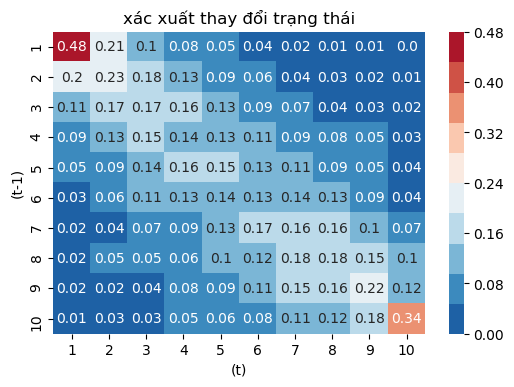

In [430]:
compare=1

quintile = len(data['outcome'].unique())
gr0 = data.groupby(['outcome',data.columns[-1-compare]]).agg(len)['t-2']
gr1 = data.groupby(['outcome']).agg(len)['t-2']
gr = gr0/gr1
cr = pd.concat([pd.DataFrame(gr.loc[i]).T for i in range(1,quintile+1)], axis=0).values.round(2)
#cr_df = pd.DataFrame(cr)
#cr_df.columns = range(1,quintile+1)
#cr_df.index = range(1,quintile+1)

fig, ax = plt.subplots(dpi=100)
sns.heatmap(cr, fmt='', annot=True, cmap=cmap, ax=ax)
ax.set_xticklabels(range(1,quintile+1))
ax.set_yticklabels(range(1,quintile+1))
ax.set_ylabel('(t-1)')
ax.set_xlabel('(t)')
plt.title('xác xuất thay đổi trạng thái')
plt.show()

Text(0.5, 1, 'Correlation matrix')

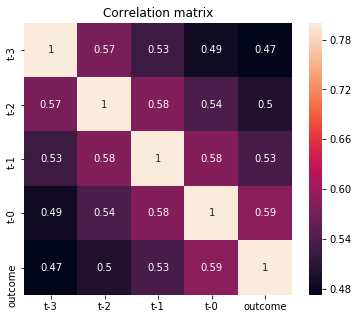

In [431]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(6, 5))  
sns.heatmap(corrmat, vmax=.8, annot=True)
plt.title('Correlation matrix')

## Method 1 : Regression

###  Data train - test split

In [432]:
from sklearn.model_selection import train_test_split

X = data.drop(['outcome'],axis=1)
y = data['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state = 15,
    stratify = y
)

## GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

# define GridSearchCV
regressions = [
    [GridSearchCV(
        estimator=RandomForestRegressor(n_jobs=-1),param_grid={
            'n_estimators': [200, 500],
            'max_features': ['sqrt', 'log2'],
            'max_depth': [ 5,7,8,9],
        }, 
        scoring='r2', cv=3, n_jobs=-1), 
     "RF"],
    [GridSearchCV(
        estimator=SVR(), param_grid={
            'C': [1e0, 1e1, 1e2],
            'gamma': np.logspace(-2, 2, 5)
        }, scoring='r2', cv=3, n_jobs=-1), 
     "SVR"],
    [GridSearchCV(
        estimator=LinearRegression(), param_grid={
            'normalize': [False, True],
        }, scoring='r2', cv=3, n_jobs=-1), 
     "LR"],
]
# solver 
results = []
for reg in regressions:
    reg[0].fit(X, y)
    results.append((reg[1], reg[0].best_score_, reg[0].best_params_))
results = pd.DataFrame(results, columns=['regression', 'r2', 'best_params']) 
results

In [435]:
import statsmodels.api as sm      
X_train1 = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train1).fit()
print(lm.summary())
pred = lm.predict(sm.add_constant(X_test))

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1077.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        10:45:40   Log-Likelihood:                -12348.
No. Observations:                5631   AIC:                         2.471e+04
Df Residuals:                    5626   BIC:                         2.474e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0071      0.073     13.791      0.0

Select best model : LinearRegression

regr = LinearRegression()
print(regressions[-1][0].best_params_)
regr.set_params(**regressions[-1][0].best_params_)
regr.fit(X_train, y_train)
pred = regr.predict(X_test)
print(regr.score(X_test, y_test))
pd.Series(pred).describe()

**Phân phối của dự báo so với thực tế:**

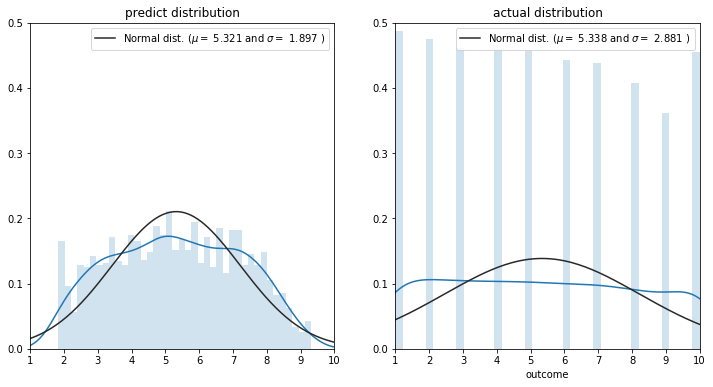

In [436]:
from scipy.stats import norm
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
for ax, ys, title in zip(axs,[pred,y_test],['predict','actual']):
    ax.set_xlim(1,NBIN)
    ax.set_ylim(0,0.5)
    sns.distplot(ys,
                 fit=norm,
                 hist_kws={"alpha":0.2},
                 norm_hist=True,
                 bins = 40,
                 ax = ax)
    (mu, sigma) = norm.fit(ys)
    ax.set_title(title + ' distribution')
    ax.legend(['Normal dist. ($\mu=$ {:.3f} and $\sigma=$ {:.3f} )'.format(mu,sigma)])

In [437]:
for target in targets:
    print(target[1], target[0])

20% [9, 10]
30% [8, 9, 10]


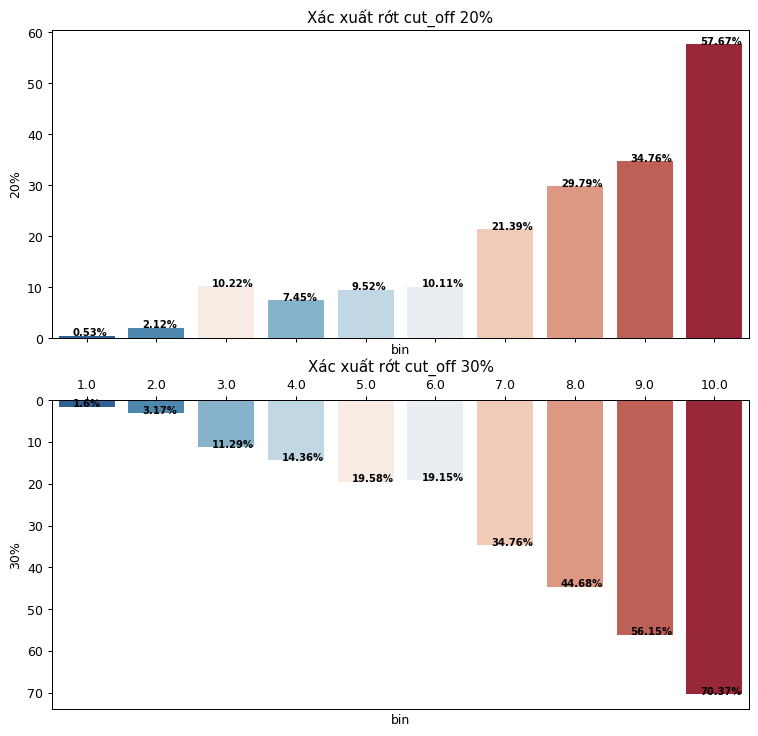

In [438]:
def make_bins(pred, y_test, targets, quintile=10,):
    cuts = pd.qcut(pred,quintile,precision=5).unique()
    df_probs = pd.DataFrame({'score' : pred,
                             'y' : y_test})
    cuts = pd.qcut(pred, quintile,precision=5).unique()
    for i,cut in enumerate(cuts.categories):
        left = 0 if i == 0 else cut.left
        right = quintile if i == quintile-1 else cut.right
        df_probs.loc[(df_probs.score > left) &(df_probs.score <= right),'bin'] =  i +1 
        df_probs.loc[(df_probs.score > left) &(df_probs.score <= right),'bin_value'] = cut

    total = df_probs.groupby('bin').agg(len)['score'] 
    df_range = pd.DataFrame({'total': total})
    for target in targets:
        df_probs[target[1]] = [1 if x in (target[0]) else 0 for x in  df_probs.y.tolist()]
        count_g = df_probs.groupby('bin').sum()[target[1]]/total * 100
        count_g.name = target[1]
        df_range = pd.concat([df_range, count_g], axis=1)

    fig, axs = plt.subplots(nrows = len(targets), figsize = (10,10), dpi=90,sharex=True)
    for i, ax, target in zip(range(len(targets)), axs, targets):
        ax.set_xlim(0,max(df_range[target[1]]) + 10)
        #df_range[[target[1]]].plot.barh(width=0.2, ax=ax, color=cmap[1], alpha=0.3)
        sns.barplot(x=df_range.index, y=target[1], data=df_range ,
                palette=cmap,hue=target[1],dodge=False,ax = ax)
        #ax.scatter(y=df_range.index-1, x=df_range[[target[1]]],color=cmap[1], s=260)
        plus = 8 if i%2 == 0 else 1
        
        for xi,yi in zip(df_range.index-1,df_range[target[1]]):
            ax.text(xi-0.2, yi,str(round(yi,2))+ '%', fontweight='bold',fontsize = 8)
        ax.legend().remove()
        ax.set_title('Xác xuất rớt cut_off '+ target[1])
    #if len(targets) == 2:
    axs[1].xaxis.tick_top()
    axs[1].invert_yaxis()
    return df_probs, df_range

df_probs, df_range = make_bins(pred, y_test, targets, quintile=10)

posx and posy should be finite values


[[9, 10], '20%']
[[8, 9, 10], '30%']
0
1


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


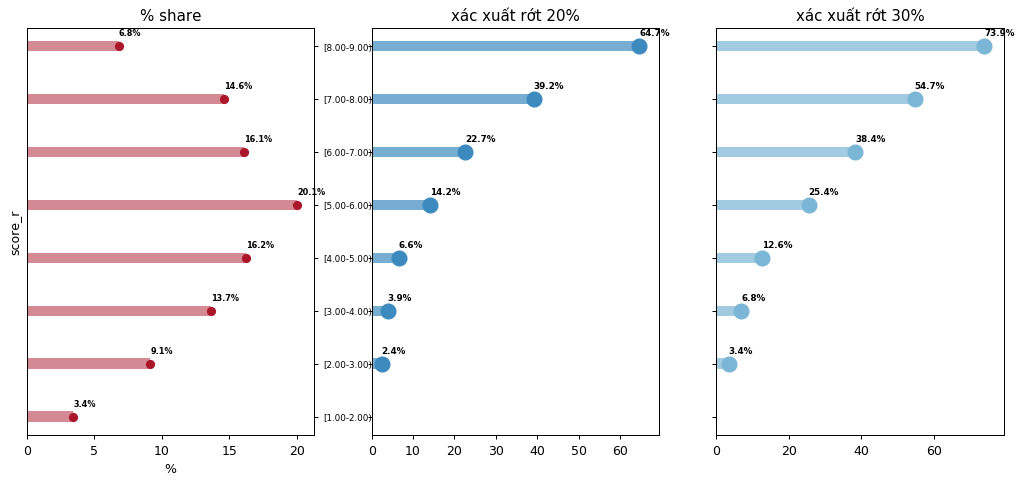

In [452]:
def score_PN_rate(df_probs, iter_n=1):
    for i in np.arange(0, max(df_probs['score']), iter_n):
        df_probs.loc[(df_probs.score>=i)& (df_probs.score < i+iter_n), 'score_r'] = '[%.2f-%.2f)'%(i, i+iter_n)    
    dts = []
    for target in targets:
        print(target)
        x1=df_probs[df_probs.y.isin(target[0])].groupby(['score_r']).agg(len)[['y']]
        x1.columns = [target[1] +'P']
        x0=df_probs[~df_probs.y.isin(target[0])].groupby(['score_r']).agg(len)[['y']]
        x0.columns = [target[1] +'N']
        x = df_probs.groupby(['score_r']).agg(len)[['y']]
        x = x.merge(x1,how='left', on='score_r')
        x = x.merge(x0,how='left', on='score_r')
        #x.columns = ['count', 'P','N']
        x['P'] = x[target[1] +'P']/x['y'] * 100
        x['#'] = x['y'] * 100 / x['y'].sum()   
        dts.append(x)
    dts 
    fig, axs = plt.subplots(ncols=len(targets)+1, figsize=(14,6), sharey=True, dpi=90)
    #x[['P']].plot.barh(ax = axs[1], width=0.2, color=cmap[1], alpha=0.5)
    dts[0][['#']].plot.barh(ax = axs[0], width=0.2, color=cmap[-1], alpha=0.5)
    #axs[0].invert_xaxis()
    axs[0].scatter(y=x.index, x=x['#'],color=cmap[-1], s=40)
    axs[0].yaxis.tick_right()
    axs[0].tick_params(axis='y',labelsize=7)    
    for yi,xi in enumerate(dts[0]['#'].tolist()):
        axs[0].text(xi, yi+0.2, '%.1f'%(xi) + '%', fontsize=6.5, fontweight='bold')
    # %P
    axs[0].get_legend().remove()  
    axs[0].set_xlabel('%')
    axs[0].set_title('% share')
    for i, ax in enumerate(axs[1:]):
        print(i)
        dts[i][['P']].plot.barh(ax = ax, width=0.2, color=cmap[1+i], alpha=0.7)
        ax.scatter(y=dts[i].index, x=dts[i]['P'],color=cmap[1+i], s=140)
        for yt, xt in enumerate(dts[i]['P'].tolist()):
            ax.text(xt, yt+0.2, '%.1f'%(xt) + '%', fontsize=7, fontweight='bold')   
        ax.get_legend().remove()       
        ax.set_title(f'xác xuất rớt {targets[i][1]}')
score_PN_rate(df_probs, iter_n=1)

## Method 0 : MOVING AVERAGE:

In [456]:
dataMA3 = data.copy()
x = dataMA3[dataMA3.columns.difference(['outcome'])] * weight
dataMA3['wma'] = x.sum(axis=1)
dataMA3.head()


,t-3,t-2,t-1,t-0,outcome,wma
0,4.0,5.0,2.0,6.0,6.0,4.25
1,6.0,8.0,5.0,9.0,10.0,6.90
2,1.0,2.0,3.0,5.0,3.0,2.45
3,9.0,9.0,6.0,10.0,10.0,8.60
4,4.0,3.0,1.0,5.0,5.0,3.35


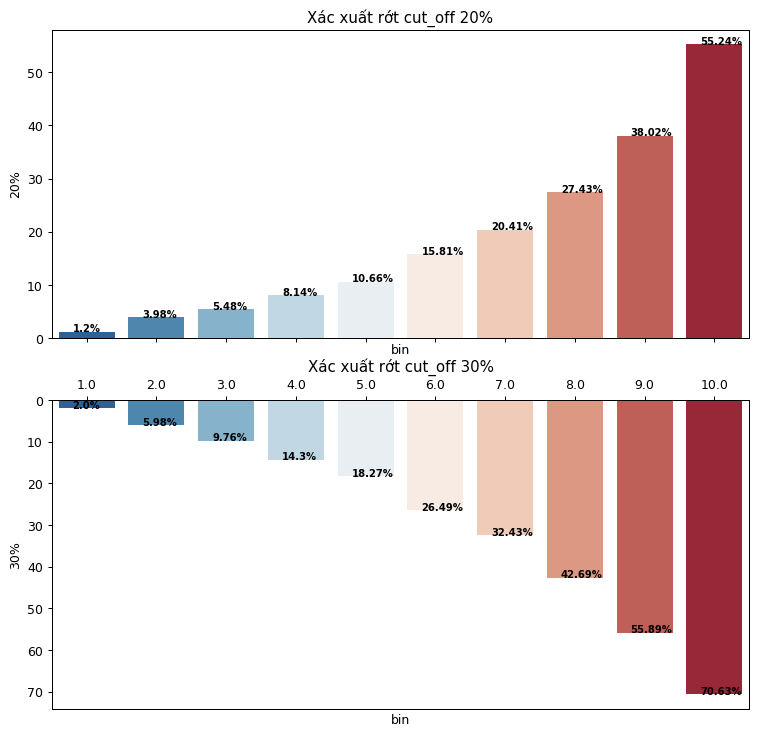

In [454]:
df_probsma, df_rangema = make_bins(dataMA3.wma, dataMA3.outcome, targets, quintile=10)

[[9, 10], '20%']
[[8, 9, 10], '30%']
0
1


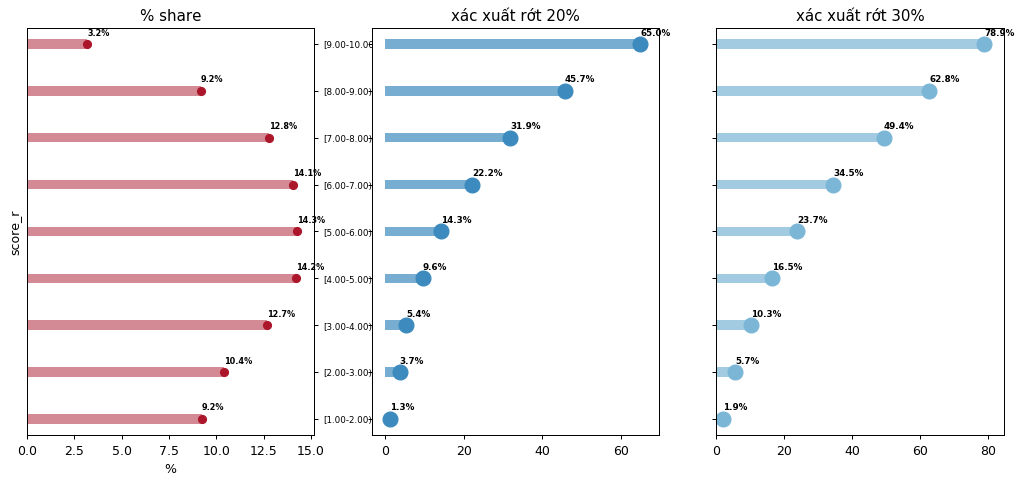

In [455]:
score_PN_rate(df_probsma, iter_n=1)

In [458]:
from sklearn.model_selection import train_test_split

X = dataMA3.drop(['outcome'],axis=1)
y = dataMA3['outcome']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state = 15,
    stratify = y
)

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.434
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     1077.
Date:                Tue, 21 Apr 2020   Prob (F-statistic):               0.00
Time:                        11:13:00   Log-Likelihood:                -12348.
No. Observations:                5631   AIC:                         2.471e+04
Df Residuals:                    5626   BIC:                         2.474e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0071      0.073     13.791      0.0

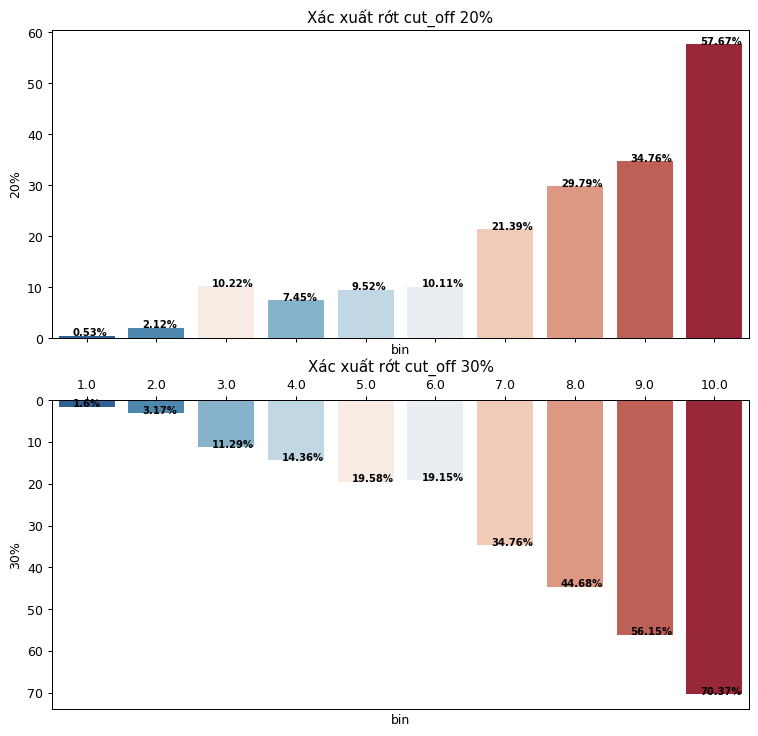

In [462]:
X_train1 = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train1).fit()
print(lm.summary())
pred = lm.predict(sm.add_constant(X_test))
df_probs, df_range = make_bins(pred, y_test, targets, quintile=10)

## Method 2 : Deep learning LSTM model:

Dữ liệu có tính chất chuỗi thời gian nên có thể mạng Long short-term memory sẽ có thể rút tríc được nhiều thông tin hơn từ dữ liệu.

In [444]:
# from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential

# Xay dung model LSTM
warnings.filterwarnings('ignore')

# Xay dung model LSTM
regressor = Sequential()
regressor.add(LSTM(units = 10, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 10, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 10))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

#regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
#regressor.compile(loss='mean_squared_error',
regressor.compile(loss='mean_squared_error',
              optimizer='adam',)
regressor.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 4, 10)             480       
_________________________________________________________________
dropout_21 (Dropout)         (None, 4, 10)             0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 4, 10)             840       
_________________________________________________________________
dropout_22 (Dropout)         (None, 4, 10)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 4, 10)             840       
_________________________________________________________________
dropout_23 (Dropout)         (None, 4, 10)             0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 10)               

In [445]:
numOfEpoch = 500
H = regressor.fit(X_train, y_train, 
              epochs=numOfEpoch, 
              batch_size=1000, 
              #validation_data=(X_test, y_test), 
              verbose=-1)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [446]:
pred = regressor.predict(X_test)
pred = pred.reshape(pred.shape[0])
y_test = y_test.reshape(y_test.shape[0])

**Phân phối của dự báo so với thực tế:**

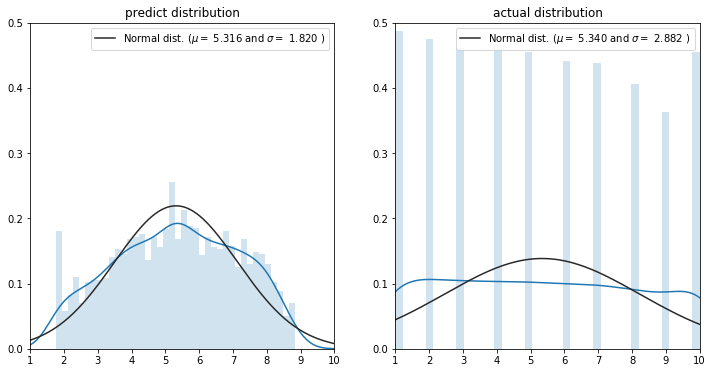

In [447]:
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
for ax, ys, title in zip(axs,[pred,y_test],['predict','actual']):
    ax.set_xlim(1,NBIN)
    ax.set_ylim(0,0.5)
    sns.distplot(ys,
                 fit=norm,
                 hist_kws={"alpha":0.2},
                 norm_hist=True,
                 bins = 40,
                 ax = ax)
    (mu, sigma) = norm.fit(ys)
    ax.set_title(title + ' distribution')
    ax.legend(['Normal dist. ($\mu=$ {:.3f} and $\sigma=$ {:.3f} )'.format(mu,sigma)])

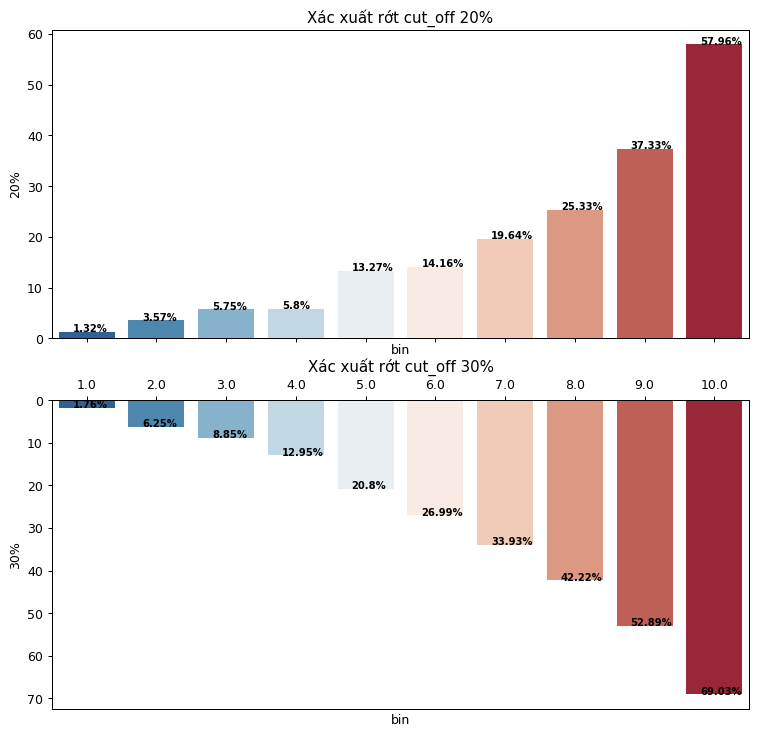

In [448]:
df_probs, df_range = make_bins(pred, y_test, targets, quintile=10)

[[9, 10], '20%']
[[8, 9, 10], '30%']
0
1


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


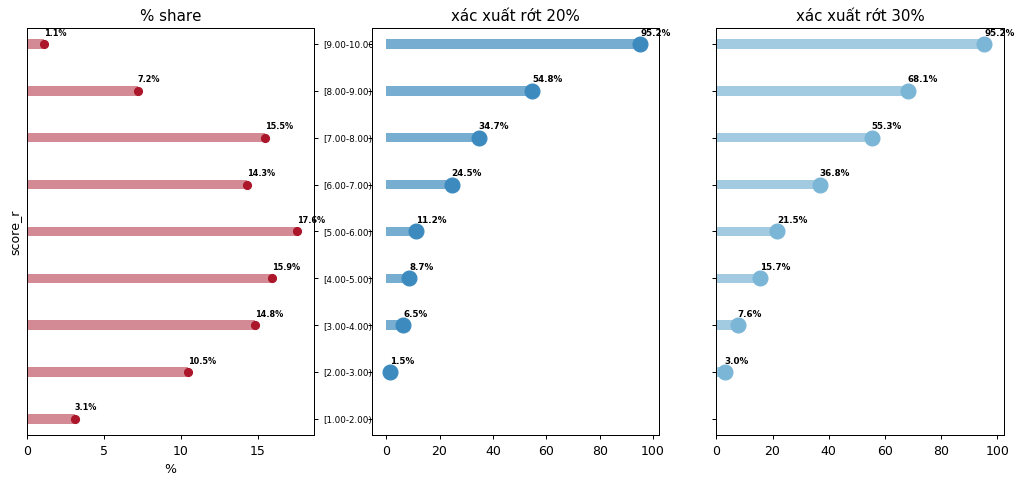

In [464]:
score_PN_rate(df_probs, iter_n=1)     